In [1]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install -Uq botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.0/625.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 7.5 MB/s eta 0:00:00


In [3]:
!rm -rf censored_regressors
!git clone https://github.com/AndreaKarlova/censored_regressors.git

Cloning into 'censored_regressors'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 158 (delta 73), reused 111 (delta 31), pack-reused 0
Receiving objects: 100% (158/158), 21.10 MiB | 27.94 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [4]:
import tqdm
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
import math
from numbers import Number, Real

import botorch
import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

import importlib
from censored_regressors.src.censored_normal import CensoredNormal
from censored_regressors.src.censored_likelihood import CensoredGaussianLikelihood, CensoredGaussianLikelihoodAnalytic, CensoredGaussianLikelihoodMathematica

In [11]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood

In [19]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret


def plot_result(pred_samples, y_preds, censored=False, title='Estimated function', is_gaussian=False):
    if censored:
        c_pred = pred_samples > MAX_VALUE
        pred_samples[c_pred] = MAX_VALUE
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
      pred_median = np.median(pred_samples, axis=0)
      pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

      plt.figure(figsize=(6, 4))
      plt.plot(domain, pred_median)
      plt.plot(domain, noise_free_target(domain), alpha=0.5, color='grey');

      plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
      plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');
      if is_gaussian:
        plt.plot(domain, y_preds.sample_n(n=10000).mean([0]).numpy(force=True), 'r--', color='purple')
      else:
        plt.plot(domain, y_preds.sample_n(n=10000).mean([0, 1]).numpy(force=True), 'r--', color='purple')

      plt.plot(x, y, 'k.');
      plt.plot(domain, torch.clamp_max(torch.clamp_min(noise_free_target(domain), MIN_VALUE), MAX_VALUE), 'k--', alpha=0.5);
      plt.xlim(0, 1);
      plt.ylim(-9, 9);
      if title is not None:
        plt.title(title)

# Synthetic 1D

In [7]:
MIN_VALUE = -1e4
MAX_VALUE = 0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

# def oracle(x):
#     return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , 0.0)

def oracle(x, noise_scale=1):
    noised = noise_free_target(x) + noise_scale * torch.randn(x.shape)
    return torch.clamp_max(torch.clamp_min(noised , MIN_VALUE), MAX_VALUE)

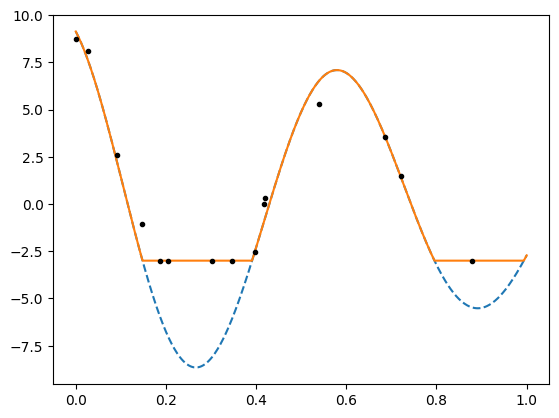

In [18]:
N_init = 15
# np.random.seed(3)
# x = torch.FloatTensor(np.random.rand(N_init))
# torch.sort(x)
# y = oracle(x, noise_scale=1)

domain = torch.linspace(0, 1, 500)
plt.plot(domain, noise_free_target(domain), '--');
plt.plot(domain, torch.clamp_max(torch.clamp_min(noise_free_target(domain), MIN_VALUE), MAX_VALUE), '-');
# plt.plot(x, y, 'k.')

# GP Implementation

In [8]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import MeanFieldVariationalDistribution, CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, covariance_type='cholesky'):
        # defines approximation
        if covariance_type == 'cholesky':
          variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        elif covariance_type == 'mean_field':
          variational_distribution = MeanFieldVariationalDistribution(inducing_points.size(0))
        else:
          raise ValueError("Unknown covariance_type.")
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP prior
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        # for line in traceback.format_stack():
        #   print(line.strip())
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Case 1: left censored data

In [9]:
MIN_VALUE, MAX_VALUE = -3, 10000.0
x =  torch.FloatTensor([4.1702e-01, 7.2032e-01, 1.1437e-04, 3.0233e-01, 1.4676e-01, 9.2339e-02,
         1.8626e-01, 3.4556e-01, 3.9677e-01, 5.3882e-01, 4.1919e-01, 6.8522e-01,
         2.0445e-01, 8.7812e-01, 2.7388e-02])
y = torch.FloatTensor([ 0.0156,  1.4708,  8.7187, -3.0000, -1.0862,  2.5984, -3.0000, -3.0000,
         -2.5664,  5.2993,  0.3283,  3.5685, -3.0000, -3.0000,  8.1062])

In [15]:
analytical_model = GPModel(inducing_points=x[:,None], covariance_type='cholesky')
analytical_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE-1e-6, high=MAX_VALUE+1e-6,
                                                              alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    analytical_model = analytical_model.cuda()
    analytical_likelihood = analytical_likelihood.cuda()

lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 10 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
analytical_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
analytical_model.covar_module.initialize(outputscale=y.var());
analytical_model.mean_module.initialize(constant=y.mean())
analytical_likelihood.noise.initialize(noise=(y.std()/kappa).square());

analytical_model.train()
analytical_likelihood.train()
analytical_model.train_inputs = (x[:,None],)
analytical_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(analytical_likelihood, analytical_model, num_data=y.size(0))
res =botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)

OptimizationResult(step=253, fval=1.5786800384521484, status=<OptimizationStatus.SUCCESS: 2>, runtime=2.8745268310000256, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
<ipython-input-19-2f6b6b1f3a4c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(domain, y_preds.sample_n(n=10000).mean([0, 1]).numpy(force=True), 'r--', color='purple')


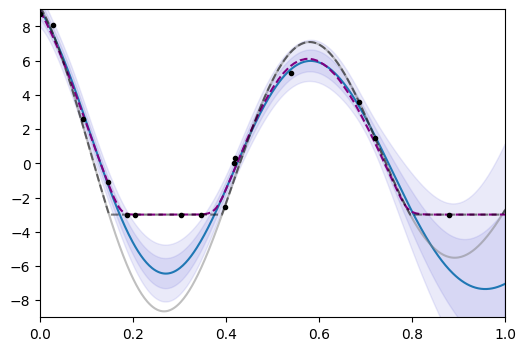

In [20]:
analytical_model.eval()
analytical_likelihood.eval()

f_preds = analytical_model(domain[:,None])
analytical_y_preds = analytical_likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])
plot_result(pred_samples, analytical_y_preds, title=None)
# plt.savefig('analytical-bfgs-%d.png' % iter)

## Case 2: symmetrically censored data

In [21]:
MIN_VALUE, MAX_VALUE, x, y = (-2,
 2,
 torch.FloatTensor([0.5488, 0.7152, 0.6028, 0.5449, 0.4237, 0.6459, 0.4376, 0.8918, 0.9637,
         0.3834, 0.7917, 0.5289, 0.5680, 0.9256, 0.0710]),
 torch.FloatTensor([ 2.0000,  1.4446,  2.0000,  2.0000,  0.2617,  2.0000,  0.6661, -2.0000,
         -2.0000, -2.0000, -1.7687,  2.0000,  2.0000, -2.0000,  2.0000]))

In [22]:
analytical_model = GPModel(inducing_points=x[:,None], covariance_type='cholesky')
analytical_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE-1e-6, high=MAX_VALUE+1e-6,
                                                              alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    analytical_model = analytical_model.cuda()
    analytical_likelihood = analytical_likelihood.cuda()

lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 10 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
analytical_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
analytical_model.covar_module.initialize(outputscale=y.var());
analytical_model.mean_module.initialize(constant=y.mean())
analytical_likelihood.noise.initialize(noise=(y.std()/kappa).square());

analytical_model.train()
analytical_likelihood.train()
analytical_model.train_inputs = (x[:,None],)
analytical_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(analytical_likelihood, analytical_model, num_data=y.size(0))
res =botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)

OptimizationResult(step=236, fval=0.8237859010696411, status=<OptimizationStatus.SUCCESS: 2>, runtime=2.9458577160000914, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
<ipython-input-19-2f6b6b1f3a4c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(domain, y_preds.sample_n(n=10000).mean([0, 1]).numpy(force=True), 'r--', color='purple')


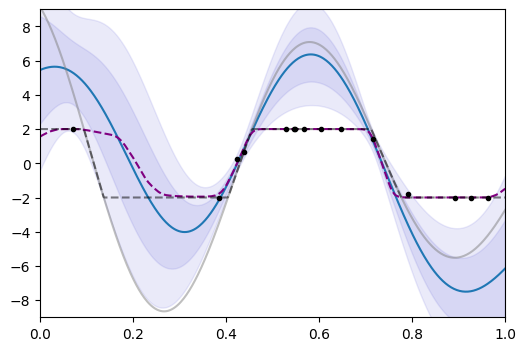

In [23]:
analytical_model.eval()
analytical_likelihood.eval()

f_preds = analytical_model(domain[:,None])
analytical_y_preds = analytical_likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])
plot_result(pred_samples, analytical_y_preds, title=None)
# plt.savefig('analytical-bfgs-%d.png' % iter)

## Case 3: right censored data

In [27]:
MIN_VALUE, MAX_VALUE, x, y = (-10000.0,
 0,
 torch.FloatTensor([0.5508, 0.7081, 0.2909, 0.5108, 0.8929, 0.8963, 0.1256, 0.2072, 0.0515,
         0.4408, 0.0299, 0.4568, 0.6491, 0.2785, 0.6763]),
 torch.FloatTensor([ 0.0000,  0.0000, -8.2198,  0.0000, -4.5298, -4.5752, -1.9043, -8.1565,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -8.6780,  0.0000]))


In [28]:
analytical_model = GPModel(inducing_points=x[:,None], covariance_type='cholesky')
analytical_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE-1e-6, high=MAX_VALUE+1e-6,
                                                              alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    analytical_model = analytical_model.cuda()
    analytical_likelihood = analytical_likelihood.cuda()

lmbd = 4 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 10 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
analytical_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
analytical_model.covar_module.initialize(outputscale=y.var());
analytical_model.mean_module.initialize(constant=y.mean())
analytical_likelihood.noise.initialize(noise=(y.std()/kappa).square());

analytical_model.train()
analytical_likelihood.train()
analytical_model.train_inputs = (x[:,None],)
analytical_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(analytical_likelihood, analytical_model, num_data=y.size(0))
res =botorch.fit.fit_gpytorch_mll_scipy(mll)
print(res)

OptimizationResult(step=522, fval=1.0232630968093872, status=<OptimizationStatus.SUCCESS: 2>, runtime=7.6842864870000085, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
<ipython-input-19-2f6b6b1f3a4c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument wi

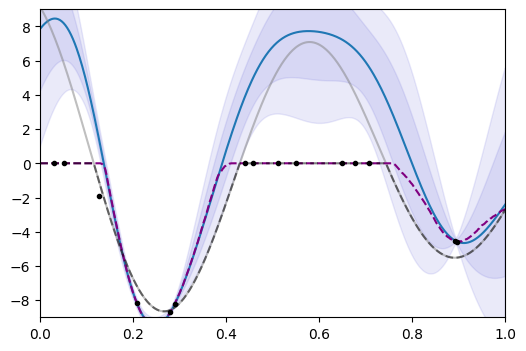

In [29]:
analytical_model.eval()
analytical_likelihood.eval()

f_preds = analytical_model(domain[:,None])
analytical_y_preds = analytical_likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])
plot_result(pred_samples, analytical_y_preds, title=None)
# plt.savefig('analytical-bfgs-%d.png' % iter)